For my MSDS 599 final project, I decided to use machine learning to see: a) if data indicates a true number of baseball pitch types and how these pitch types differ from convention, and b) to see how info on pitch differences might be used to predict effectiveness.  

I addressed this two-parted across three sections. In the first section, I deploy an unsupervised learning model on a dozen or so variables tracking exactly how a pitch moves through the air after its release. 

The second and third sections get at the second part of my question. Specificaly, I look to see whether I can predict a swing and a miss, which is a good indication of pitch effectiveness. First, I deploy a machine learning model without any information gained via my unsupervised learning model. Then, I build a model using insights gained from that unsupervised learning model.  

I used Statcast data pulled from Baseball Savant, looking at 40,000 pitches thrown over an 11-day sample period last May. It has dozens of columns, but I limit myself to just 36 that provide just about everything you could want to know about a given pitch. 

For my unsupervised portion, I limit myself to just the dozen or so features that measure what a pitch is doing in the air. These are:  
- release_speed: pitch velocity in MPH
- pfx_x: horizontal movement in feet
- pfx_z: vertical movement in feet
- vx0: velocity of the pitch, in feet per second, in x-dimension, determined at y=50 feet
- vy0: velocity of the pitch, in feet per second, in y-dimension, determined at y=50 feet
- vz0: velocity of the pitch, in feet per second, in z-dimension, determined at y=50 feet
- ax: acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet
- ay: acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet
- az: acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet
- release_spin_rate: in revolutions per minute
- spin_axis: The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball.  

Some of these could be redundant, such as release_speed and velocity at 50 feet, but movement occuring later in a pitch's flight as opposed to early makes [a big difference](https://www.youtube.com/shorts/cnYVYpMfqKA).  

For my supervised portion, my analysis at first consisted of all the information in these above-mentioned variables, plus a dozen or so more. These are mostly locational, e.g. release position and pitch location relative to the plate. For predictive purposes I also engineer a feature capturing *previous pitch* information, as what a batter has seen the previous pitch can greatly affect their chances against the next one. I then use insights from section 1 to streamline this information into a lighter model.

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [166]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from tqdm import tqdm

In [168]:
from sklearn.model_selection import train_test_split

In [169]:
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

In [170]:
mlb_raw = pd.read_csv('/content/drive/MyDrive/Data/savant_data (2).csv')

In [171]:
#(for part 2) sorting values chronologically -- by unique game ID, at_bat number, and pitch number -- for engineering new features with prior pitch info
mlb_raw.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'], ascending=False, inplace=True)

In [172]:
#listing columns of interest
cols_of_interest1 = ['pitch_type', 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'pitcher',
 'events',
 'zone',
 'p_throws',
 'type',
 'balls',
 'strikes',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'hc_x',
 'hc_y',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'release_pos_y',
 'at_bat_number',
 'pitch_number',
 'pitch_name',
 'spin_axis', 
 'description']

# **Section 1**

# Unsupervised Learning: Clustering Pitch Types

In [173]:
features = ['release_speed', 'pfx_x',	'pfx_z', 'vx0',	'vy0', 'vz0',	'ax', 'ay', 'az', 'release_spin_rate', 'spin_axis']

In [174]:
#filtering columns, splitting by handedness, dropping NA rows, and then finally filtering to features measuring pitch trajectory.
pitches = mlb_raw.copy()[cols_of_interest1]
righties = pitches[pitches['p_throws'] == 'R']
lefties = pitches[pitches['p_throws'] == 'L']
righties.dropna(inplace=True)
lefties.dropna(inplace=True)
righty_features = righties[features]
lefty_features = lefties[features]

#scaling
scaler = StandardScaler()
righty_features_scaled = scaler.fit_transform(righty_features)
lefty_features_scaled = scaler.fit_transform(lefty_features)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# K-Means Clustering

In [175]:
#using the function from the lecture to inform number-of-clusters decisions
def km_mse(inputs,k):
    mse=[]
    for i in range(1,k):
        errors=[]
        kmeans = KMeans(n_clusters=i, n_init=50,random_state=0).fit(inputs)
        for pt,lab in zip(inputs,kmeans.labels_):
            errors.append(np.linalg.norm(pt-kmeans.cluster_centers_[lab])**2)
        mse.append(np.mean(errors))
    return mse

Righties

In [176]:
mse=km_mse(righty_features_scaled, 10)

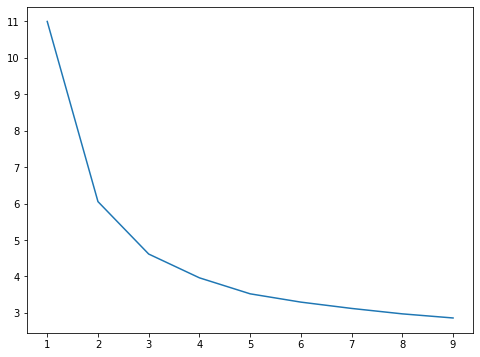

In [177]:
plt.figure(figsize=(8,6))
plt.plot(list(range(1,10)),mse)
plt.show()

Lefties

In [178]:
mse2=km_mse(lefty_features_scaled, 10)

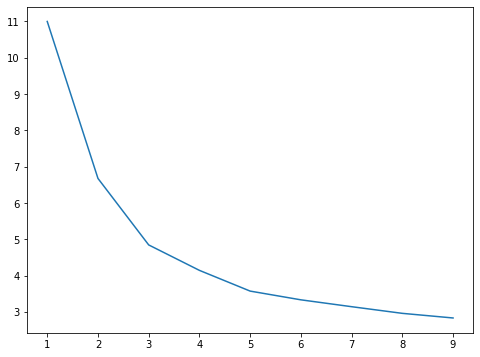

In [179]:
plt.figure(figsize=(8,6))
plt.plot(list(range(1,10)),mse2)
plt.show()

For both righties and lefties, we see defined elbows at 2 clusters and similarly defined but slightly less distinguishable ones at 3. 

Now, I'll fit models based on handedness and use 3 clusters, which could be a sensible way to think about different pitches based on their characteristics. 

In [180]:
#fitting the models based on handedness
kmeans_righties = KMeans(n_clusters=3, random_state=0).fit(righty_features_scaled)
kmeans_lefties = KMeans(n_clusters=3, random_state=0).fit(lefty_features_scaled)

In [181]:
righty_features['Cluster'] = kmeans_righties.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [182]:
lefty_features['Cluster'] = kmeans_lefties.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


By looking how features differ by cluster, we can get a sense of what sorts of pitches are grouped together here. The most obvious place to look first is at release speed. Then we can look at how some of the more obscure movement statistics differ by cluster. 

In [183]:
print(righty_features[righty_features['Cluster'] == 0]['release_speed'].mean())
print(righty_features[righty_features['Cluster'] == 1]['release_speed'].mean())
print(righty_features[righty_features['Cluster'] == 2]['release_speed'].mean())

83.35543710021317
93.88065075921922
86.22591206735262


In [184]:
print(lefty_features[lefty_features['Cluster'] == 0]['release_speed'].mean())
print(lefty_features[lefty_features['Cluster'] == 1]['release_speed'].mean())
print(lefty_features[lefty_features['Cluster'] == 2]['release_speed'].mean())

92.54576446280977
85.05763888888893
82.08881431767335


It's not surprising there looks to be a cluster for what are fastballs ('1' for righties, '0' for lefties. Fastballs are characterized by being much faster and straighter than other pitches.

In [185]:
#looking like fastballs to me
righty_features[righty_features['Cluster'] == 1].describe()

,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis,Cluster
count,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.0
mean,93.880651,-0.746698,1.192629,6.113841,-136.501975,-5.663962,-10.737821,30.118898,-16.189106,2306.822560,210.993059,1.0
std,2.306057,0.478655,0.358041,2.234076,3.341522,1.881505,6.251695,2.738411,4.742691,196.429302,14.974340,0.0
min,86.200000,-1.930000,0.050000,-1.304490,-147.486189,-12.068774,-26.883057,22.371699,-30.945733,1301.000000,94.000000,1.0
25%,92.500000,-1.110000,0.950000,4.668295,-138.697684,-6.851628,-15.474843,28.251452,-19.519757,2170.000000,203.000000,1.0
50%,93.900000,-0.750000,1.250000,6.177074,-136.487731,-5.654003,-10.807949,30.073647,-15.532577,2303.000000,211.000000,1.0
75%,95.400000,-0.410000,1.470000,7.584422,-134.436888,-4.365839,-6.343924,31.946999,-12.556253,2429.000000,220.000000,1.0
max,101.300000,0.620000,1.990000,14.155221,-125.129496,1.201784,6.996810,40.161057,-5.590773,3139.000000,330.000000,1.0


In [186]:
#lefty fastballs
lefty_features[lefty_features['Cluster'] == 0].describe()

,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis,Cluster
count,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.0
mean,92.545764,0.684029,1.286105,-6.180042,-134.534721,-5.894424,9.715905,29.377427,-15.437885,2258.913223,148.052686,0.0
std,2.621304,0.456635,0.299210,2.433750,3.790196,1.885385,5.813461,2.787131,3.991392,196.230861,14.492387,0.0
min,83.400000,-0.610000,0.060000,-14.220082,-147.492485,-11.414792,-5.416831,20.276131,-30.558772,1523.000000,75.000000,0.0
25%,91.000000,0.367500,1.100000,-7.849864,-136.915770,-7.190943,5.636997,27.408246,-18.040951,2120.750000,139.750000,0.0
50%,92.600000,0.690000,1.320000,-6.144896,-134.592958,-5.825346,9.864673,29.307875,-15.034411,2265.500000,147.000000,0.0
75%,94.200000,1.020000,1.500000,-4.425229,-132.270820,-4.598480,13.818703,31.202296,-12.678463,2396.250000,156.000000,0.0
max,101.600000,1.790000,1.930000,0.502764,-121.272049,-0.559669,23.593620,39.847159,-3.315677,2876.000000,252.000000,0.0


In [187]:
righty_features[righty_features['Cluster'] == 1][['release_speed', 'pfx_x', 'pfx_z', 'release_spin_rate']].describe()

,release_speed,pfx_x,pfx_z,release_spin_rate
count,2305.000000,2305.000000,2305.000000,2305.000000
mean,93.880651,-0.746698,1.192629,2306.822560
std,2.306057,0.478655,0.358041,196.429302
min,86.200000,-1.930000,0.050000,1301.000000
25%,92.500000,-1.110000,0.950000,2170.000000
50%,93.900000,-0.750000,1.250000,2303.000000
75%,95.400000,-0.410000,1.470000,2429.000000
max,101.300000,0.620000,1.990000,3139.000000


Now's a good time to consider some other features and how they tend to differ by conventional pitch categorizations. Definitions are given by Baseball Savant and typical ranges are gleaned from stats during the last week of April 2022. Spoiler alert: Along with release speed, spin rates are where the biggest differences across clusters are, so the below info on movement is less important to digest. 
- pfx_x: horizontal movement in feet, where positive values indicate leftward movement from the behind-the-pitcher/TV camera perspective and negative values the opposite direction. 
  - Righty fastballs (e.g. four-seams, two-seams, sinkers, cutters) seem to range from between around -1.5 to 0.5 ft., lefties' from -0.5 to 1.5.
  - Righty breaking balls (e.g. sliders and curveballs) seem to range between 0 and 2 feet, lefties from -2 and 0 feet.
  - Righty off-speed pitches (e.g. changeups and splitters) seem to range from between -2 to 0 feet, lefties from 0 to 2 feet.
- pfx_z: vertical movement in feet
  - Righty and lefty fastballs both seem to "rise" between 0 and 2 ft.
  - Lefty breaking balls seem to drop between 0 and 2 ft, whereas righty ones, interesingly enough, seem to range from dropping 1.5 feet to *rising* about 1.25 feet. (I think this difference comes from the fact lots of righties' advantages are to have some weird pitching styles, like the [Giants' own Tyler Rogers](https://baseballsavant.mlb.com/sporty-videos?playId=549dcbe5-ec78-4d8f-964a-c14198912f1c).)
  - Righty and lefty off-speed pitches seem to range from dropping 0.5 feet to rising 1.5.
- release_spin_rate: in RPMs
  - Righty and lefty fastballs both seem to range from 1800 to 2700 RPMs
  - Righty and lefty breaking balls seem to range from between 1800 to 3200 RPM
  - Righty and lefty off-speed pitches seem to range from between 1000 and 2,500 RPMs

All this noted and focusing on spin rates below, I think we can see that the k-means clustering algorithm has made clusters that at least roughly correspond to overarching pitch types of fastballs, breaking balls, and off-speed pitches. For righties, it looks like off-speed pitches tend to be labeled into cluster 1 and breaking pitches cluster 0. Likewise, for lefties, it looks like off-speed pitches are categorized as cluster 2, breaking pitches cluster 1.



In [188]:
#low velocity/low spin-rate averages characteristic of off-speed pitches
righty_features[righty_features['Cluster'] == 2].describe()

,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis,Cluster
count,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.0
mean,86.225912,-1.037212,0.533742,6.310307,-125.405509,-3.189550,-12.250444,24.814995,-26.124896,1867.962582,234.160898,2.0
std,3.815844,0.490689,0.432629,2.114117,5.548511,2.484904,5.550580,2.908207,4.745820,323.603442,26.341006,0.0
min,55.800000,-2.080000,-1.330000,0.217235,-140.526550,-8.591611,-23.820903,11.350073,-48.041875,645.000000,65.000000,2.0
25%,84.500000,-1.370000,0.270000,4.854209,-128.614522,-4.686162,-16.197106,22.992074,-28.950350,1653.000000,221.000000,2.0
50%,86.400000,-1.170000,0.550000,6.274705,-125.673839,-3.511460,-13.438218,24.883501,-25.915015,1884.000000,232.000000,2.0
75%,88.400000,-0.850000,0.790000,7.753098,-122.915765,-2.211103,-9.690853,26.698403,-23.251729,2080.000000,245.000000,2.0
max,96.600000,0.350000,1.630000,14.063577,-81.018151,13.951024,2.690208,36.362509,-14.615326,3141.000000,357.000000,2.0


In [189]:
#low velocity/high spin-rate averages characteristic of breaking pitches
righty_features[righty_features['Cluster'] == 0].describe()

,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis,Cluster
count,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.0
mean,83.355437,0.610519,-0.149552,3.519325,-121.364346,-1.821216,5.182746,23.600075,-33.164291,2529.479033,86.686567,0.0
std,4.144438,0.389699,0.616469,1.981780,6.066014,2.325495,3.607048,2.537953,6.000580,271.473005,52.734586,0.0
min,51.600000,-0.200000,-1.840000,-2.266805,-134.774500,-9.110119,-2.968519,10.529892,-48.516489,1043.000000,0.000000,0.0
25%,81.000000,0.330000,-0.535000,2.135602,-125.738325,-3.461873,2.660631,22.027338,-37.359037,2350.500000,45.000000,0.0
50%,83.900000,0.540000,-0.030000,3.518118,-122.217672,-1.989681,4.757406,23.605393,-32.409410,2511.000000,72.000000,0.0
75%,86.300000,0.840000,0.300000,4.979155,-117.864182,-0.340916,7.314326,25.331832,-28.647718,2717.000000,124.000000,0.0
max,92.500000,2.400000,1.440000,9.411594,-74.895677,8.617230,20.828075,35.978380,-19.445531,3514.000000,360.000000,0.0


In [190]:
#low velocity/low spin-rate averages characteristic of off-speed pitches
lefty_features[lefty_features['Cluster'] == 1].describe()

,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis,Cluster
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.0
mean,85.057639,1.042413,0.588698,-6.417032,-123.700329,-2.973775,12.111351,24.345039,-25.828224,1865.352431,123.074653,1.0
std,4.557621,0.474632,0.403694,2.358557,6.585939,2.124019,5.484050,3.005056,4.187014,296.198704,26.108462,0.0
min,62.000000,-0.330000,-0.350000,-15.386673,-140.471016,-8.182777,-2.351765,12.847724,-36.482430,1030.000000,7.000000,1.0
25%,82.400000,0.880000,0.310000,-7.614014,-127.985336,-4.549507,9.614061,22.341057,-28.702886,1653.750000,116.000000,1.0
50%,85.000000,1.155000,0.575000,-6.074707,-123.645326,-3.182057,12.831944,24.369892,-25.490873,1887.500000,127.000000,1.0
75%,87.925000,1.370000,0.860000,-4.852093,-119.848409,-1.822474,15.743871,26.381799,-23.018941,2093.250000,136.000000,1.0
max,96.600000,1.830000,1.630000,-0.527634,-90.271862,5.166024,24.366974,31.459735,-15.682719,2987.000000,228.000000,1.0


In [191]:
#low velocity/high spin-rate averages characteristic of breaking pitches
lefty_features[lefty_features['Cluster'] == 2].describe()

,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,spin_axis,Cluster
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.0
mean,82.088814,-0.594049,-0.107181,-3.547256,-119.516277,-1.841012,-4.839713,22.905892,-32.673210,2439.597315,271.438479,2.0
std,4.389409,0.414239,0.573628,1.986703,6.428037,2.196203,3.663771,2.297765,5.507976,259.869187,57.992578,0.0
min,56.200000,-1.870000,-1.560000,-10.878217,-131.804572,-6.966495,-14.687103,10.667895,-44.845203,1219.000000,21.000000,2.0
25%,79.600000,-0.825000,-0.415000,-5.031374,-124.019505,-3.396555,-6.958148,21.602732,-35.986426,2266.000000,213.500000,2.0
50%,82.500000,-0.470000,-0.050000,-3.544220,-120.176004,-1.942641,-4.079148,22.837048,-32.668210,2438.000000,296.000000,2.0
75%,85.100000,-0.300000,0.305000,-2.011056,-115.896966,-0.536037,-2.158095,24.363760,-28.701754,2619.500000,316.500000,2.0
max,90.400000,0.120000,1.310000,1.213252,-81.869212,4.321122,1.884239,31.414538,-20.366686,3303.000000,351.000000,2.0


I now look to see how these clusters match up against the conventional pitch labels given in the data. Using conventional wisdom, I'll encode each pitch name and cluster as either Fastball, Breaking Ball, or Offspeed Pitch and then see how often they match up and where some discrepancies are. 

In [192]:
#re-incorporating label info
righty_features_appended = pd.merge(righty_features, righties[['pitch_name', 'player_name']], left_index=True, right_index=True)
lefty_features_appended = pd.merge(lefty_features, lefties[['pitch_name', 'player_name']], left_index=True, right_index=True)

In [193]:
#defining the functions
def righty_cluster_classifier(df):
  if df['Cluster'] == 0:
    return 'Breaking Pitch'
  if df['Cluster'] == 1:
    return 'Fastball'
  if df['Cluster'] == 2:
    return 'Offspeed Pitch'

def lefty_cluster_classifier(df):
  if df['Cluster'] == 0:
    return 'Fastball'
  if df['Cluster'] == 1:
    return 'Offspeed Pitch'
  if df['Cluster'] == 2:
    return 'Breaking Pitch'

def pitch_classifier(df):
  if (df['pitch_name'] == '4-Seam Fastball') | (df['pitch_name'] == 'Sinker') | (df['pitch_name'] == 'Cutter') | (df['pitch_name'] == 'Fastball'):
    return 'Fastball'
  if (df['pitch_name'] == 'Changeup') | (df['pitch_name'] == 'Split-Finger'):
    return 'Offspeed Pitch'
  else:
    return 'Breaking Pitch'

In [194]:
#applying the functions
righty_features_appended['Cluster_Assignment'] = righty_features_appended.apply(righty_cluster_classifier, axis=1)
righty_features_appended['Actual_Label'] = righty_features_appended.apply(pitch_classifier, axis=1)
lefty_features_appended['Cluster_Assignment'] = lefty_features_appended.apply(lefty_cluster_classifier, axis=1)
lefty_features_appended['Actual_Label'] = lefty_features_appended.apply(pitch_classifier, axis=1)

Starting with righties, I'll look at what percentage of pitches have cluster discrepancies and, of these pitches, what their specific conventional pitch type labels are. We can see what pitches show up disproportionally (relative to their actual usage amount). 

In [195]:
(righty_features_appended['Cluster_Assignment'] != righty_features_appended['Actual_Label']).apply(lambda x: int(x)).sum()

546

In [196]:
len(righty_features_appended)

4781

In [197]:
(righty_features_appended['Cluster_Assignment'] != righty_features_appended['Actual_Label']).apply(lambda x: int(x)).sum() / len(righty_features_appended)

0.11420204978038068

In [198]:
righty_features_appended[righty_features_appended['Cluster_Assignment'] != righty_features_appended['Actual_Label']]['pitch_name'].value_counts() / 546

Cutter             0.346154
Sinker             0.318681
Slider             0.221612
4-Seam Fastball    0.067766
Changeup           0.025641
Curveball          0.010989
Fastball           0.007326
Split-Finger       0.001832
Name: pitch_name, dtype: float64

In [199]:
righty_features_appended['pitch_name'].value_counts() / 4781

4-Seam Fastball    0.325037
Slider             0.197448
Sinker             0.165865
Changeup           0.137837
Curveball          0.069232
Cutter             0.064631
Knuckle Curve      0.022171
Split-Finger       0.016942
Fastball           0.000837
Name: pitch_name, dtype: float64

For righties, we see that about 11% of pitches are classified differently. Cutters and sinkers make up about two-thirds of all discrepancies despite making up only about 23% of pitches. Conversely, fastballs are behind just under 7% of discrepancies despite composing about a third of all pitches.

In [200]:
pd.crosstab(righty_features_appended[righty_features_appended['Cluster_Assignment'] != righty_features_appended['Actual_Label']]['Cluster_Assignment'], 
              righty_features_appended[righty_features_appended['Cluster_Assignment'] != righty_features_appended['Actual_Label']]['Actual_Label'])

Actual_Label,Breaking Pitch,Fastball,Offspeed Pitch
Cluster_Assignment,,,
Breaking Pitch,0,153,0
Fastball,34,0,15
Offspeed Pitch,93,251,0


Most discrepancies were fastballs being put in the breaking pitch or offspeed pitch clusters.

We do the same things for lefties.

In [201]:
(lefty_features_appended['Cluster_Assignment'] != lefty_features_appended['Actual_Label']).apply(lambda x: int(x)).sum()

319

In [202]:
len(lefty_features_appended)

1991

In [203]:
(lefty_features_appended['Cluster_Assignment'] != lefty_features_appended['Actual_Label']).apply(lambda x: int(x)).sum() / len(lefty_features_appended)

0.16022099447513813

In [204]:
lefty_features_appended[lefty_features_appended['Cluster_Assignment'] != lefty_features_appended['Actual_Label']]['pitch_name'].value_counts() / 319

Sinker             0.410658
Cutter             0.332288
Slider             0.103448
4-Seam Fastball    0.047022
Changeup           0.047022
Curveball          0.037618
Fastball           0.021944
Name: pitch_name, dtype: float64

In [205]:
lefty_features_appended['pitch_name'].value_counts() / 1991

4-Seam Fastball    0.353089
Changeup           0.183325
Sinker             0.160221
Slider             0.136113
Cutter             0.086389
Curveball          0.066298
Knuckle Curve      0.008538
Fastball           0.003516
Split-Finger       0.002511
Name: pitch_name, dtype: float64

In [206]:
pd.crosstab(lefty_features_appended[lefty_features_appended['Cluster_Assignment'] != lefty_features_appended['Actual_Label']]['Cluster_Assignment'], 
              lefty_features_appended[lefty_features_appended['Cluster_Assignment'] != lefty_features_appended['Actual_Label']]['Actual_Label'])

Actual_Label,Breaking Pitch,Fastball,Offspeed Pitch
Cluster_Assignment,,,
Breaking Pitch,0,72,0
Fastball,11,0,15
Offspeed Pitch,34,187,0


For lefties, we see something similar: sinkers and sliders are the pitchest with the most relative discrepancies.  

However, we do see some differences from the righties. About 16% of pitches have classification discrepancies. Also, sinkers make up almost half of all such discrepancies. And we see a greater proportion of fastballs being put in the offspeed pitch cluster. 

Overall, we have:

In [207]:
print(f'Righty label discrepancy rate: {546 / 4781}')
print(f'Lefty label discrepancy rate: {319 / 1991}')

Righty label discrepancy rate: 0.11420204978038068
Lefty label discrepancy rate: 0.16022099447513813


Aside from there being less lefty data, I think another possible reason for lefty pitches seeing more labeling discrepancies is that there's probably a wider range of professional left-handed pitchers than there is of righties. For being rarer, lefties can usually get away with having less fast fastballs or less breaking breaking pitches because they have the advantage of batters being less accustomed to them. But of course, you'll also have lefties with incredible physical abilities as well.  

Another quick look at the fastball clusters shows this dynamic playing out in terms of release speed. Lefties have a lower average velocity, wider interquartile range, and higher standard deviation, though a lefty actually comes out on top in terms of fastest pitch observed during this 11-day period.

In [208]:
#lefty fastballs
lefty_features[lefty_features['Cluster'] == 0]['release_speed'].describe()

count    968.000000
mean      92.545764
std        2.621304
min       83.400000
25%       91.000000
50%       92.600000
75%       94.200000
max      101.600000
Name: release_speed, dtype: float64

In [209]:
#looking like fastballs to me
righty_features[righty_features['Cluster'] == 1]['release_speed'].describe()

count    2305.000000
mean       93.880651
std         2.306057
min        86.200000
25%        92.500000
50%        93.900000
75%        95.400000
max       101.300000
Name: release_speed, dtype: float64

In [210]:
#102 mph
mlb_raw[mlb_raw['release_speed'] == mlb_raw['release_speed'].max()]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
19760,SI,2021-05-11,102.5,1.14,6.37,"Alvarado, José",665742,621237,NaN,blocked_ball,...,3,3,2,2,3,Standard,Standard,154.0,0.0,0.052


# **Section 2**

# Supervised Learning: Predicting Swings and Misses 

Now I'll look to see how well pitch characteristics can be used to predict whether a batter swung and missed. This label is engineered from the dataset's 'description' variable. The balance of the dataset turns out to be pretty consistent with season-long trends: About 10% of all pitches are swung on and missed.  

Continuing with the handedness dichotomy, I break the data into lefty and righty sets to build two models. I also decide to use previous pitch data in the models. This means applying functions seperately -- i.e. to each hands' training and validation sets -- that, for pitches 2 and later in an at-bat, populate columns with previous pitch info, and for pitch 1 of an at-bat, will impute training set medians, which should approximate league averages for those hands. 

I think this all requires that the data go unshuffled before being split into training and test sets, that way previous pitch info is readily available. And wanting to avoid data leakage, I can't impute training set first pitch observations with training set medians without having split the data first.  

I think this is worth it. As mentioned, the previous pitch of an at-bat influences the effectiveness of the upcoming one. For instance, a changeup should be much, much more likely to be swung on and missed if following a fastball than if following a changeup.  

Below, I create the datasets necessary for my model(s). I create previous pitch columns with temporary values to be replaced later. 

In [211]:
#adding label
pitches['Missed_Swing'] = (pitches['description'].str.contains('swinging_strike')).apply(int)

#breaking by handedness and dropping observations with NAs in variable columns
righty_set = pitches[pitches['p_throws'] == 'R'].dropna(subset=['release_spin_rate', 'spin_axis', 'release_extension'])
lefty_set = pitches[pitches['p_throws'] == 'L'].dropna(subset=['release_spin_rate', 'spin_axis', 'release_extension'])

#creating columns to populate

#original is 2nd column index
righty_set['prev_release_speed'] = 37 #taking the 37th column index, and so on...
lefty_set['prev_release_speed'] = 37

#original is 13th column index
righty_set['prev_pfx_x'] = 38
lefty_set['prev_pfx_x'] = 38

#original is 14th column index
righty_set['prev_pfx_z'] = 39
lefty_set['prev_pfx_z'] = 39

#original is 19th column index
righty_set['prev_vx0'] = 40
lefty_set['prev_vx0'] = 40

#original is 20th column index
righty_set['prev_vy0'] = 41
lefty_set['prev_vy0'] = 41

#original is 21st column index
righty_set['prev_vz0'] = 42
lefty_set['prev_vz0'] = 42

#original is 22nd column index
righty_set['prev_ax'] = 43
lefty_set['prev_ax'] = 43

#original is 23rd column index
righty_set['prev_ay'] = 44
lefty_set['prev_ay'] = 44

#original is 24th column index
righty_set['prev_az'] = 45
lefty_set['prev_az'] = 45

#original is 28th column index
righty_set['prev_release_spin_rate'] = 46
lefty_set['prev_release_spin_rate'] = 46

#original is 35 column index
righty_set['prev_spin_axis'] = 47
lefty_set['prev_spin_axis'] = 47

Now I'll split each dataframe into training, validation, and test sets. 

In [212]:
#righty split
righty_features = righty_set.drop('Missed_Swing', axis=1)
righty_label = righty_set['Missed_Swing']
righty_train_features, righty_temp_features, righty_train_y, righty_temp_y = train_test_split(righty_features, righty_label, test_size=0.50, random_state=5, shuffle=False)
righty_val_features, righty_test_features, righty_val_y, righty_test_y = train_test_split(righty_temp_features, righty_temp_y, test_size=0.25, random_state=5, shuffle=False)

#lefty split
lefty_features = lefty_set.drop('Missed_Swing', axis=1)
lefty_label = lefty_set['Missed_Swing']
lefty_train_features, lefty_temp_features, lefty_train_y, lefty_temp_y = train_test_split(lefty_features, lefty_label, test_size=0.50, random_state=5, shuffle=False)
lefty_val_features, lefty_test_features, lefty_val_y, lefty_test_y = train_test_split(lefty_temp_features, lefty_temp_y, test_size=0.25, random_state=5, shuffle=False)

In [213]:
print(righty_train_features['release_speed'].median(), righty_train_features['pfx_x'].median(), righty_train_features['pfx_z'].median(), 
      righty_train_features['vx0'].median(), righty_train_features['vy0'].median(), righty_train_features['vz0'].median(), 
      righty_train_features['ax'].median(), righty_train_features['ay'].median(), righty_train_features['az'].median(), 
      righty_train_features['release_spin_rate'].median(), righty_train_features['spin_axis'].median())

90.1 -0.51 0.76 5.543552910520634 -131.09852129848025 -4.27602536598665 -7.496699973974847 26.930507111799727 -22.850722218471827 2315.0 207.0


Now I'll correctly populate those previous pitch columns. I define functions to do so and use them. 

In [214]:
def righty_prev_pitch_info(df):
  z = 0
  while z < (len(df) - 1):
    if (df.iloc[z + 1, 30] == df.iloc[z, 30]) & (df.iloc[z, 33] != 1):
      df.iloc[z, 37] = df.iloc[z + 1, 2]
      df.iloc[z, 38] = df.iloc[z + 1, 13]
      df.iloc[z, 39] = df.iloc[z + 1, 14]
      df.iloc[z, 40] = df.iloc[z + 1, 19]
      df.iloc[z, 41] = df.iloc[z + 1, 20]
      df.iloc[z, 42] = df.iloc[z + 1, 21]
      df.iloc[z, 43] = df.iloc[z + 1, 22]
      df.iloc[z, 44] = df.iloc[z + 1, 23]
      df.iloc[z, 45] = df.iloc[z + 1, 24]
      df.iloc[z, 46] = df.iloc[z + 1, 28]
      df.iloc[z, 47] = df.iloc[z + 1, 35]
    else:
      df.iloc[z, 37] = 90.1
      df.iloc[z, 38] = -0.51
      df.iloc[z, 39] = 0.76
      df.iloc[z, 40] = 5.543552910520634
      df.iloc[z, 41] = -131.09852129848025
      df.iloc[z, 42] = -4.27602536598665
      df.iloc[z, 43] = -7.496699973974847
      df.iloc[z, 44] = 26.930507111799727
      df.iloc[z, 45] = -22.850722218471827
      df.iloc[z, 46] = 2315.0
      df.iloc[z, 47] = 207.0
    z += 1
  df.iloc[len(df) - 1, 37] = 90.1
  df.iloc[len(df) - 1, 38] = -0.51
  df.iloc[len(df) - 1, 39] = 0.76
  df.iloc[len(df) - 1, 40] = 5.543552910520634
  df.iloc[len(df) - 1, 41] = -131.09852129848025
  df.iloc[len(df) - 1, 42] = -4.27602536598665
  df.iloc[len(df) - 1, 43] = -7.496699973974847
  df.iloc[len(df) - 1, 44] = 26.930507111799727
  df.iloc[len(df) - 1, 45] = -22.850722218471827
  df.iloc[len(df) - 1, 46] = 2315.0
  df.iloc[len(df) - 1, 47] = 207.0

In [215]:
righty_prev_pitch_info(righty_train_features)

In [216]:
righty_prev_pitch_info(righty_val_features)
righty_prev_pitch_info(righty_test_features)

In [217]:
print(lefty_train_features['release_speed'].median(), lefty_train_features['pfx_x'].median(), lefty_train_features['pfx_z'].median(), 
      lefty_train_features['vx0'].median(), lefty_train_features['vy0'].median(), lefty_train_features['vz0'].median(), 
      lefty_train_features['ax'].median(), lefty_train_features['ay'].median(), lefty_train_features['az'].median(), 
      lefty_train_features['release_spin_rate'].median(), lefty_train_features['spin_axis'].median())

88.6 0.55 0.89 -5.80599411955417 -128.8998603078395 -4.330774558708322 7.823901037796297 26.429918314192925 -21.686642796533818 2249.0 149.0


In [218]:
def lefty_prev_pitch_info(df):
  z = 0
  while z < (len(df) - 1):
    if (df.iloc[z + 1, 30] == df.iloc[z, 30]) & (df.iloc[z, 33] != 1):
      df.iloc[z, 37] = df.iloc[z + 1, 2]
      df.iloc[z, 38] = df.iloc[z + 1, 13]
      df.iloc[z, 39] = df.iloc[z + 1, 14]
      df.iloc[z, 40] = df.iloc[z + 1, 19]
      df.iloc[z, 41] = df.iloc[z + 1, 20]
      df.iloc[z, 42] = df.iloc[z + 1, 21]
      df.iloc[z, 43] = df.iloc[z + 1, 22]
      df.iloc[z, 44] = df.iloc[z + 1, 23]
      df.iloc[z, 45] = df.iloc[z + 1, 24]
      df.iloc[z, 46] = df.iloc[z + 1, 28]
      df.iloc[z, 47] = df.iloc[z + 1, 35]
    else:
      df.iloc[z, 37] = 88.6
      df.iloc[z, 38] = 0.55
      df.iloc[z, 39] = 0.89
      df.iloc[z, 40] = -5.80599411955417
      df.iloc[z, 41] = -128.8998603078395
      df.iloc[z, 42] = -4.330774558708322
      df.iloc[z, 43] = 7.823901037796297
      df.iloc[z, 44] = 26.429918314192925
      df.iloc[z, 45] = -21.686642796533818
      df.iloc[z, 46] = 2249.0
      df.iloc[z, 47] = 149.0
    z += 1
  df.iloc[len(df) - 1, 37] = 88.6
  df.iloc[len(df) - 1, 38] = 0.55
  df.iloc[len(df) - 1, 39] = 0.89
  df.iloc[len(df) - 1, 40] = -5.80599411955417
  df.iloc[len(df) - 1, 41] = -128.8998603078395
  df.iloc[len(df) - 1, 42] = -4.330774558708322
  df.iloc[len(df) - 1, 43] = 7.823901037796297
  df.iloc[len(df) - 1, 44] = 26.429918314192925
  df.iloc[len(df) - 1, 45] = -21.686642796533818
  df.iloc[len(df) - 1, 46] = 2249.0
  df.iloc[len(df) - 1, 47] = 149.0

In [219]:
lefty_prev_pitch_info(lefty_train_features)

In [220]:
lefty_prev_pitch_info(lefty_val_features)
lefty_prev_pitch_info(lefty_test_features)

In [221]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Now I filter to features and scale them for later use.

In [222]:
X_list = ['release_speed', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'spin_axis', 'release_pos_x', 'release_pos_z', 'zone', 'balls', 'strikes', 'plate_x', 'plate_z', 'effective_speed', 'release_extension', 'release_pos_y', 'prev_release_speed', 'prev_pfx_x', 'prev_pfx_z', 'prev_vx0', 'prev_vy0', 'prev_vz0', 'prev_ax', 'prev_ay', 'prev_az', 'prev_release_spin_rate', 'prev_spin_axis']

righty_train_X = righty_train_features[X_list]
righty_train_X_scaled = scaler.fit_transform(righty_train_X)

righty_val_X = righty_val_features[X_list]
righty_val_X_scaled = scaler.fit_transform(righty_val_X)

righty_test_X = righty_test_features[X_list]
righty_test_X_scaled = scaler.fit_transform(righty_test_X)


lefty_train_X = lefty_train_features[X_list]
lefty_train_X_scaled = scaler.fit_transform(lefty_train_X)

lefty_val_X = lefty_val_features[X_list]
lefty_val_X_scaled = scaler.fit_transform(lefty_val_X)

lefty_test_X = lefty_test_features[X_list]
lefty_test_X_scaled = scaler.fit_transform(lefty_test_X)

**Note:** In addressing my prediction task, I went through a number of different model variations and cross-validations, with models including logistic regression, k-nearest neighbors, and bagging and boosting classifiers, and modifications including weighting the loss functions behind several of those algorithms and tinkering with prediction probability thresholds.  

The upshot ended up being that, after this trial, I was unable to beat the baseline dummy model's accuracy. So instead, I resorted to trying to reasonably optimize (i.e. without decimating accuracy) recall, with the idea being that identification of swing-and-miss-quality pitches is high reward for baseball-interested people and false positives relatively uncostly.  

I end up choosing a random forest model fitted on upsampled data, with the results described below.

# Section 2 Conclusion

After doing the above cross-validation and other adjustments, I further evaluate the best lefty and righty models identified for accomplishing the task of optimizing recall without decimating overall model accuracy. 

The lefty model most up for this task among those I evaluated in Section is fit on upsampled data. Below are some of its metrics. I decide to tune it so that precision on the validation set is at least 20% before testing it. 

In [223]:
lefty_synth_train_X, lefty_synth_train_y = oversample.fit_resample(lefty_train_X, lefty_train_y)
lefty_synth_train_X_scaled = scaler.fit_transform(lefty_synth_train_X)

In [224]:
RFCLF2 = RandomForestClassifier(n_estimators=800, oob_score=True, random_state=5).fit(lefty_synth_train_X_scaled, lefty_synth_train_y)

In [225]:
np.round(RFCLF2.score(lefty_val_X_scaled, lefty_val_y), 3)

0.771

In [226]:
f1_score(lefty_val_y, RFCLF2.predict(lefty_val_X_scaled))

0.2439024390243902

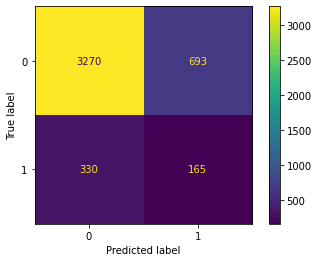

In [227]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(lefty_val_y, RFCLF2.predict(lefty_val_X_scaled))).plot()

In [228]:
print(classification_report(lefty_val_y, RFCLF2.predict(lefty_val_X_scaled)))

              precision    recall  f1-score   support

           0       0.91      0.83      0.86      3963
           1       0.19      0.33      0.24       495

    accuracy                           0.77      4458
   macro avg       0.55      0.58      0.55      4458
weighted avg       0.83      0.77      0.80      4458



In [229]:
print("Lefty AUC Score: {}".format(roc_auc_score(lefty_val_y, RFCLF2.predict_proba(lefty_val_X_scaled)[:,1])))

Lefty AUC Score: 0.6522474301429638


In [230]:
print("Lefty Average Precision Score: {}".format(average_precision_score(lefty_val_y, RFCLF2.predict_proba(lefty_val_X_scaled)[:,1])))

Lefty Average Precision Score: 0.17682318607316833


In [231]:
#lefty random forest model
pr_l, r_l, pr_thresholds_l = precision_recall_curve(lefty_val_y, RFCLF2.predict_proba(lefty_val_X_scaled)[:,1])

In [232]:
np.argmin(np.abs(pr_l-0.2))

363

In [233]:
lefty_threshold = pr_thresholds_l[363]
lefty_threshold

0.545

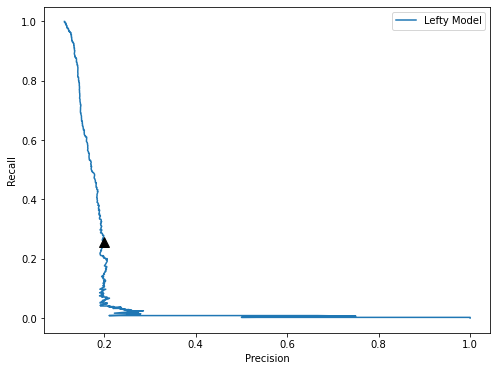

In [234]:
plt.figure(figsize=(8,6))
plt.plot(pr_l, r_l, label='Lefty Model')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(pr_l[363], r_l[363],'^',c='k',markersize=10)
plt.legend(['Lefty Model'],loc='best')
plt.show()

The righty model most up for this task was 

In [235]:
righty_synth_train_X, righty_synth_train_y = oversample.fit_resample(righty_train_X, righty_train_y)
righty_synth_train_X_scaled = scaler.fit_transform(righty_synth_train_X)

In [236]:
RFCLF_r2 = RandomForestClassifier(n_estimators=600, oob_score=True, random_state=5).fit(righty_synth_train_X_scaled, righty_synth_train_y)

In [237]:
np.round(RFCLF_r2.score(righty_val_X_scaled, righty_val_y), 3)

0.738

In [238]:
f1_score(righty_val_y, RFCLF_r2.predict(righty_val_X_scaled))

0.23731632935957858

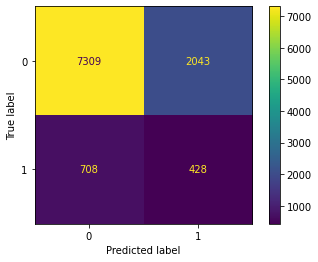

In [239]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(righty_val_y, RFCLF_r2.predict(righty_val_X_scaled))).plot()

In [240]:
print(classification_report(righty_val_y, RFCLF_r2.predict(righty_val_X_scaled)))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      9352
           1       0.17      0.38      0.24      1136

    accuracy                           0.74     10488
   macro avg       0.54      0.58      0.54     10488
weighted avg       0.83      0.74      0.78     10488



In [241]:
print("Righty AUC Score: {}".format(roc_auc_score(righty_val_y, RFCLF_r2.predict_proba(righty_val_X_scaled)[:,1])))

Righty AUC Score: 0.6495866102302438


In [242]:
print("Righty Average Precision Score: {}".format(average_precision_score(righty_val_y, RFCLF_r2.predict_proba(righty_val_X_scaled)[:,1])))

Righty Average Precision Score: 0.16958750596779654


In [243]:
#lefty random forest model
pr_2, r_2, pr_thresholds_2 = precision_recall_curve(righty_val_y, RFCLF_r2.predict_proba(righty_val_X_scaled)[:,1])

In [244]:
np.argmin(np.abs(pr_2-0.2))

440

In [245]:
righty_threshold = pr_thresholds_2[440]

In [246]:
righty_threshold

0.7916666666666666

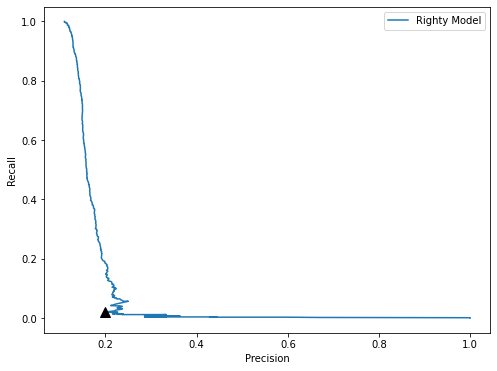

In [247]:
plt.figure(figsize=(8,6))
plt.plot(pr_2, r_2, label='Righty Model')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(pr_2[440], r_2[440],'^',c='k',markersize=10)
plt.legend(['Righty Model'],loc='best')
plt.show()

Comparing Models

In [248]:
#lefty random forest model
fpr_l, tpr_l, roc_thresholds_1 = roc_curve(lefty_val_y, RFCLF2.predict_proba(lefty_val_X_scaled)[:,1])
#righty random forest model
fpr_2, tpr_2, roc_thresholds_2 = roc_curve(righty_val_y, RFCLF_r2.predict_proba(righty_val_X_scaled)[:,1])

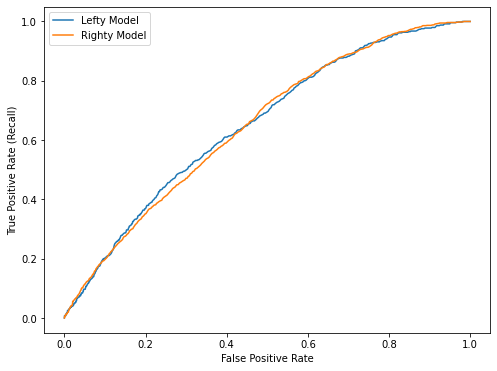

In [249]:
plt.figure(figsize=(8,6))
plt.plot(fpr_l, tpr_l, label='Lefty Model')
plt.plot(fpr_2, tpr_2, label='Righty Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(['Lefty Model','Righty Model'],loc='best')
plt.show()

Testing Models

Lefty Model

In [250]:
lefty_preds = (RFCLF2.predict_proba(lefty_test_X_scaled)[:,1] > lefty_threshold) * 1
print(classification_report(lefty_test_y, lefty_preds))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1317
           1       0.17      0.27      0.21       170

    accuracy                           0.77      1487
   macro avg       0.53      0.55      0.54      1487
weighted avg       0.81      0.77      0.79      1487



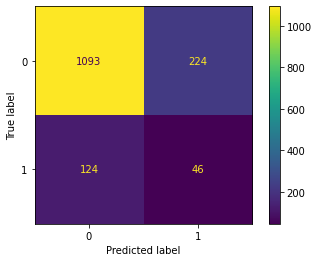

In [251]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(lefty_test_y, lefty_preds)).plot()

Righty Model

In [252]:
righty_preds = (RFCLF_r2.predict_proba(righty_test_X_scaled)[:,1] > righty_threshold) * 1
print(classification_report(righty_test_y, righty_preds))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3099
           1       0.30      0.06      0.09       398

    accuracy                           0.88      3497
   macro avg       0.59      0.52      0.51      3497
weighted avg       0.82      0.88      0.84      3497



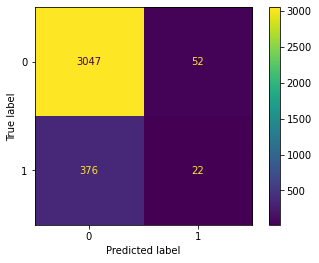

In [253]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(righty_test_y, righty_preds)).plot()

Our lefty model holds up worse against the test data in our task, while the righty model performs as the validation set indicated.  

This discrepancy might have to do with a difference in sample size. In finishing up in the final section below, I correct for a mistake I made of throwing out rows with NAs in variables I don't care about, e.g. hit coordinates. 

# **Section 3**

# Supervised Learning Models Pt. 2

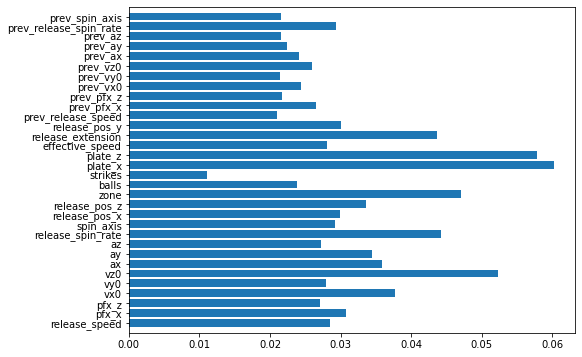

In [254]:
#lefty feature importances
plt.figure(figsize=(8,6))
nfeat=lefty_train_X.shape[1]
plt.barh(np.arange(nfeat), RFCLF2.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(lefty_train_X.columns))
plt.ylim(-1,nfeat)
plt.show()

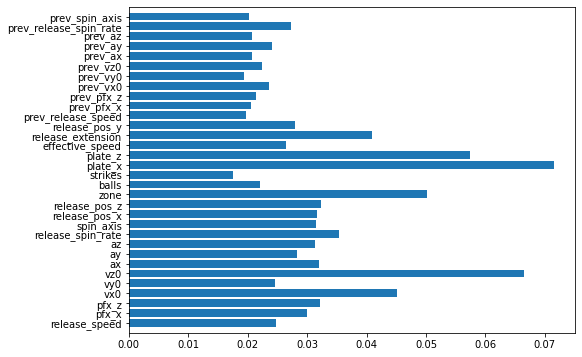

In [255]:
#righty feature importances
plt.figure(figsize=(8,6))
nfeat=righty_train_X.shape[1]
plt.barh(np.arange(nfeat), RFCLF_r2.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(righty_train_X.columns))
plt.ylim(-1,nfeat)
plt.show()

In finishing up, I will narrow down my models to a smaller subset of features along with incorporating some information analyzed through my unsupervised learning model at the beginning. (It might be the case that the random forests were the least very flawed model out of all the very flawed models because of the algorithm's feature-selection randomization.) 

From features used so far, I'll keep pitch location (plate_x, plate_z, and zone), z-direction acceleration (vz0), x-direction acceleration (vX0), release extension, and spin rate.  

In addition, because it seems like pitch location could be useful, I'll also utilize two new features, sz_top (top of strike zone) and sz_bot(bottom of strike zone). These indicate the height of a given batter's strike zone. 

Finally, we see that my previous pitch features were relatively unimportant. This time, I'll use my clustering info from before to create dummy variables indicating whether a given pitch is of a cluster different from the one that proceeded it. Like mentioned, an off-speed pitch following a fastball should be swung and missed at more often that an off-speed pitch following an off-speed pitch.  

In [256]:
new_lefty_set = pitches[pitches['p_throws'] == 'L'].dropna(subset=['release_spin_rate', 'spin_axis', 'release_extension']).copy()
new_righty_set = pitches[pitches['p_throws'] == 'R'].dropna(subset=['release_spin_rate', 'spin_axis', 'release_extension']).copy()

cluster_features = ['release_speed', 'pfx_x',	'pfx_z', 'vx0',	'vy0', 'vz0',	'ax', 'ay', 'az', 'release_spin_rate', 'spin_axis']

new_lefty_set_cluster_features = new_lefty_set[cluster_features]
new_righty_set_cluster_features = new_righty_set[cluster_features]

new_lefty_set_cluster_features_scaled = scaler.fit_transform(new_lefty_set_cluster_features)
new_righty_set_cluster_features_scaled = scaler.fit_transform(new_righty_set_cluster_features)

kmeans_lefties = KMeans(n_clusters=3, random_state=0).fit(new_lefty_set_cluster_features_scaled)
kmeans_righties = KMeans(n_clusters=3, random_state=0).fit(new_righty_set_cluster_features_scaled)

new_lefty_set['Cluster'] = kmeans_lefties.labels_
new_righty_set['Cluster'] = kmeans_righties.labels_

new_lefty_set['Missed_Swing'] = (new_lefty_set['description'].str.contains('swinging_strike')).apply(int)
new_righty_set['Missed_Swing'] = (new_righty_set['description'].str.contains('swinging_strike')).apply(int)

new_lefty_set['prev_cluster'] = 0
new_righty_set['prev_cluster'] = 0

Lefties  
- 0: off-speed
- 1: Fastball  
- 2: Breaking pitch  

Righties  
- 0: off-speed  
- 1: Breaking Pitch  
- 2: Fastball

In [257]:
#encoding first pitches in a cluster '3'
def prev_cluster_func(df):
  z = 0
  while z < (len(df) - 1):
    if (df.iloc[z + 1, 30] == df.iloc[z, 30]) & (df.iloc[z, 33] != 1):
      df.iloc[z, 39] = df.iloc[z + 1, 37]
    else:
      df.iloc[z, 39] = 3
    z += 1
  df.iloc[len(df) - 1, 39] = 3

In [258]:
prev_cluster_func(new_lefty_set)
prev_cluster_func(new_righty_set)

In [259]:
# righty train, val, test split
righty_features1 = new_righty_set.drop('Missed_Swing', axis=1)
righty_label1 = new_righty_set['Missed_Swing']
righty_train_features1, righty_temp_features1, righty_train_y1, righty_temp_y1 = train_test_split(righty_features1, righty_label1, test_size=0.50, random_state=5, shuffle=False)
righty_val_features1, righty_test_features1, righty_val_y1, righty_test_y1 = train_test_split(righty_temp_features1, righty_temp_y1, test_size=0.25, random_state=5, shuffle=False)

# lefty train, val, test split
lefty_features1 = new_lefty_set.drop('Missed_Swing', axis=1)
lefty_label1 = new_lefty_set['Missed_Swing']
lefty_train_features1, lefty_temp_features1, lefty_train_y1, lefty_temp_y1 = train_test_split(lefty_features1, lefty_label1, test_size=0.50, random_state=5, shuffle=False)
lefty_val_features1, lefty_test_features1, lefty_val_y1, lefty_test_y1 = train_test_split(lefty_temp_features1, lefty_temp_y1, test_size=0.25, random_state=5, shuffle=False)

In [260]:
new_feats = ['Cluster', 'prev_cluster', 'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'vz0', 'vx0', 'release_extension', 'release_spin_rate']

righty_train_X_2 = righty_train_features1[new_feats]
righty_val_X_2 = righty_val_features1[new_feats]
righty_test_X_2 = righty_test_features1[new_feats]

lefty_train_X_2 = lefty_train_features1[new_feats]
lefty_val_X_2 = lefty_val_features1[new_feats]
lefty_test_X_2 = lefty_test_features1[new_feats]

In [261]:
#new synthetic data
new_lefty_synth_train_X, new_lefty_synth_train_y = oversample.fit_resample(lefty_train_X_2, lefty_train_y1)
new_righty_synth_train_X, new_righty_synth_train_y = oversample.fit_resample(righty_train_X_2, righty_train_y1)

In [262]:
righty_train_X_2_scaled = scaler.fit_transform(righty_train_X_2)
righty_val_X_2_scaled = scaler.fit_transform(righty_val_X_2)
lefty_train_X_2_scaled = scaler.fit_transform(lefty_train_X_2)
lefty_val_X_2_scaled = scaler.fit_transform(lefty_val_X_2)

new_lefty_synth_train_X_scaled = scaler.fit_transform(new_lefty_synth_train_X)
new_righty_synth_train_X_scaled = scaler.fit_transform(new_righty_synth_train_X)

# Section 3 Conclusion

My best re-specified model for lefties and righties came again using random forests, this time not through upsampled data. In the same way I did in section 2, I'll further evaluate these two models before testing them. 

In [107]:
# #Random Forest 
# num_trees = np.linspace(250,800,10)
# oob_res = []
# for trees in tqdm(num_trees):
#   RFCLR = RandomForestClassifier(n_estimators=int(trees), max_features='sqrt', oob_score=True, random_state=5).fit(lefty_train_X_2, lefty_train_y1)
#   oob_res.append(RFCLR.oob_score_)

100%|██████████| 10/10 [01:17<00:00,  7.76s/it]


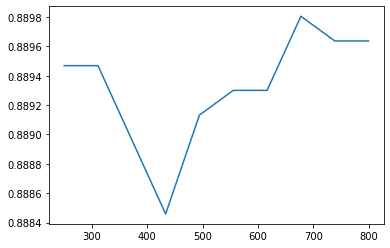

In [108]:
plt.plot(num_trees, oob_res)

In [263]:
RF_L_temp = RandomForestClassifier(n_estimators=300, max_features='sqrt', oob_score=True, random_state=5).fit(lefty_train_X_2, lefty_train_y1)

In [264]:
np.round(RF_L_temp.score(lefty_val_X_2, lefty_val_y1),3)

0.888

In [265]:
f1_score(lefty_val_y1, RF_L_temp.predict(lefty_val_X_2))

0.05649717514124294

In [266]:
average_precision_score(lefty_val_y1, RF_L_temp.predict_proba(lefty_val_X_2)[:, 1])

0.2929224061020699

In [267]:
roc_auc_score(lefty_val_y1, RF_L_temp.predict_proba(lefty_val_X_2)[:, 1])

0.7774234905196298

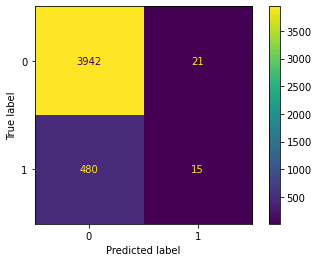

In [268]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(lefty_val_y1, RF_L_temp.predict(lefty_val_X_2))).plot()

In [ ]:
# #Random Forest
# num_trees = np.linspace(250,800,10)
# oob_res = []
# for trees in tqdm(num_trees):
#   RFCLR = RandomForestClassifier(n_estimators=int(trees), max_features='sqrt', oob_score=True, random_state=5).fit(righty_train_X_2, righty_train_y1)
#   oob_res.append(RFCLR.oob_score_)

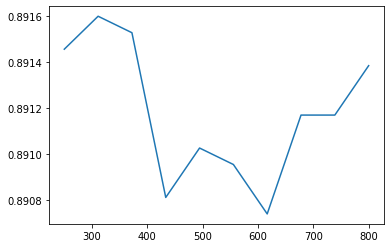

In [116]:
plt.plot(num_trees, oob_res)

In [270]:
RF_R_temp = RandomForestClassifier(n_estimators=300, max_features='sqrt', oob_score=True, random_state=5).fit(righty_train_X_2, righty_train_y1)

In [271]:
np.round(RF_R_temp.score(righty_val_X_2, righty_val_y1),3)

0.893

In [272]:
f1_score(righty_val_y1, RF_R_temp.predict(righty_val_X_2))

0.11653543307086615

In [273]:
average_precision_score(righty_val_y1, RF_R_temp.predict_proba(righty_val_X_2)[:, 1])

0.3336135986968142

In [275]:
roc_auc_score(righty_val_y1, RF_R_temp.predict_proba(righty_val_X_2)[:, 1])

0.8042016601856649

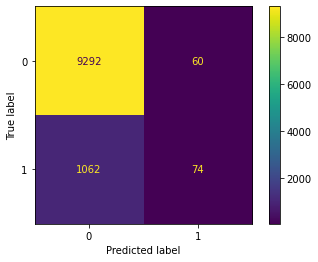

In [276]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(righty_val_y1, RF_R_temp.predict(righty_val_X_2))).plot()

Starting with the lefty model:

In [277]:
print(classification_report(lefty_val_y1, RF_L_temp.predict(lefty_val_X_2)))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3963
           1       0.42      0.03      0.06       495

    accuracy                           0.89      4458
   macro avg       0.65      0.51      0.50      4458
weighted avg       0.84      0.89      0.84      4458



In [278]:
print("Lefty AUC Score: {}".format(roc_auc_score(lefty_val_y1, RF_L_temp.predict_proba(lefty_val_X_2)[:,1])))

Lefty AUC Score: 0.7774234905196298


In [279]:
print("Lefty Average Precision Score: {}".format(average_precision_score(lefty_val_y1, RF_L_temp.predict_proba(lefty_val_X_2)[:,1])))

Lefty Average Precision Score: 0.2929224061020699


In [280]:
#lefty random forest model
pr_L1, r_L1, pr_thresholds_Ll = precision_recall_curve(lefty_val_y1, RF_L_temp.predict_proba(lefty_val_X_2)[:,1])

In [281]:
np.argmin(np.abs(pr_L1-0.2))

27

In [282]:
lefty_threshold2 = pr_thresholds_Ll[27]
lefty_threshold2

0.10333333333333333

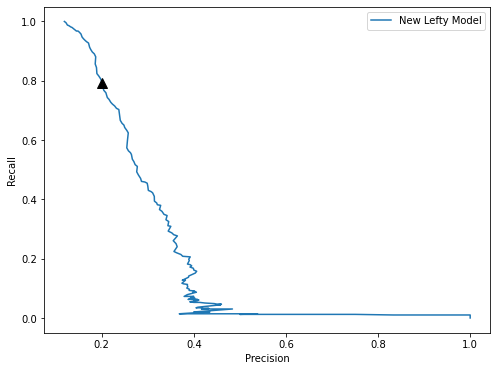

In [283]:
plt.figure(figsize=(8,6))
plt.plot(pr_L1, r_L1, label='New Lefty Model')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(pr_L1[27], r_L1[27],'^',c='k',markersize=10)
plt.legend(['New Lefty Model'],loc='best')
plt.show()

To the righty model:

In [284]:
print(classification_report(righty_val_y1, RF_R_temp.predict(righty_val_X_2)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9352
           1       0.55      0.07      0.12      1136

    accuracy                           0.89     10488
   macro avg       0.72      0.53      0.53     10488
weighted avg       0.86      0.89      0.85     10488



In [285]:
print("Righty AUC Score: {}".format(roc_auc_score(righty_val_y1, RF_R_temp.predict_proba(righty_val_X_2)[:,1])))

Righty AUC Score: 0.8042016601856649


In [286]:
print("Righty Average Precision Score: {}".format(average_precision_score(righty_val_y1, RF_R_temp.predict_proba(righty_val_X_2)[:,1])))

Righty Average Precision Score: 0.3336135986968142


In [287]:
#righty random forest model
pr_R1, r_R1, pr_thresholds_Rl = precision_recall_curve(righty_val_y1, RF_R_temp.predict_proba(righty_val_X_2)[:,1])

In [288]:
np.argmin(np.abs(pr_R1-0.2))

31

In [289]:
righty_threshold2 = pr_thresholds_Rl[31]
righty_threshold2

0.10333333333333333

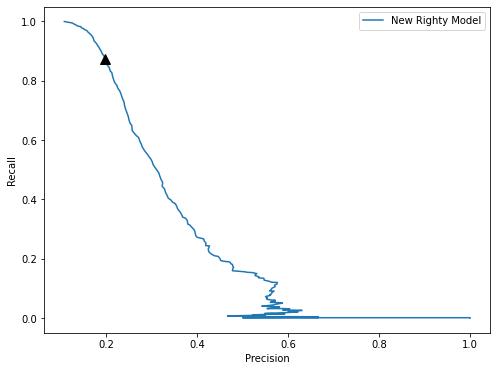

In [290]:
plt.figure(figsize=(8,6))
plt.plot(pr_R1, r_R1, label='New Righty Model')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(pr_R1[30], r_R1[30],'^',c='k',markersize=10)
plt.legend(['New Righty Model'],loc='best')
plt.show()

Comparing Models

In [291]:
#new lefty random forest model
fpr_L2, tpr_L2, roc_thresholds_L2 = roc_curve(lefty_val_y1, RF_L_temp.predict_proba(lefty_val_X_2)[:,1])
#new righty random forest model
fpr_R2, tpr_R2, roc_thresholds_R2 = roc_curve(righty_val_y1, RF_R_temp.predict_proba(righty_val_X_2)[:,1])

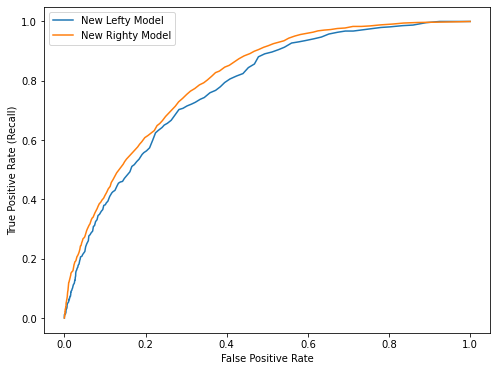

In [292]:
plt.figure(figsize=(8,6))
plt.plot(fpr_L2, tpr_L2, label='New Lefty Model')
plt.plot(fpr_R2, tpr_R2, label='New Righty Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(['New Lefty Model','New Righty Model'],loc='best')
plt.show()

Testing The Models

Final Lefty Model Compared to Earlier Version

In [293]:
lefty_preds_final = (RF_L_temp.predict_proba(lefty_test_X_2)[:,1] > lefty_threshold2) * 1
print(classification_report(lefty_test_y1, lefty_preds_final))

              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1317
           1       0.20      0.74      0.32       170

    accuracy                           0.64      1487
   macro avg       0.58      0.68      0.53      1487
weighted avg       0.86      0.64      0.70      1487



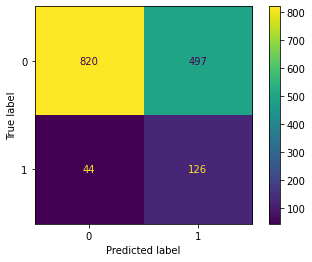

In [294]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(lefty_test_y1, lefty_preds_final)).plot()

In [295]:
lefty_preds = (RFCLF2.predict_proba(lefty_test_X_scaled)[:,1] > lefty_threshold) * 1
print(classification_report(lefty_test_y, lefty_preds))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1317
           1       0.17      0.27      0.21       170

    accuracy                           0.77      1487
   macro avg       0.53      0.55      0.54      1487
weighted avg       0.81      0.77      0.79      1487



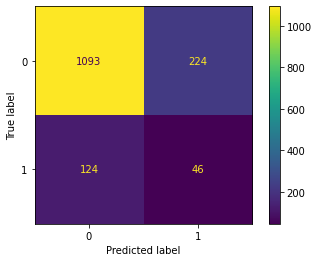

In [296]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(lefty_test_y, lefty_preds)).plot()

In once again targeting whatever recall we can get with around 20% precision, this model sees much higher recall: above 70%.  

Final Righty Model Compared to Earlier Version

In [299]:
righty_preds_final = (RF_R_temp.predict_proba(righty_test_X_2)[:,1] > righty_threshold2) * 1
print(classification_report(righty_test_y1, righty_preds_final))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75      3099
           1       0.22      0.85      0.35       398

    accuracy                           0.64      3497
   macro avg       0.59      0.73      0.55      3497
weighted avg       0.88      0.64      0.70      3497



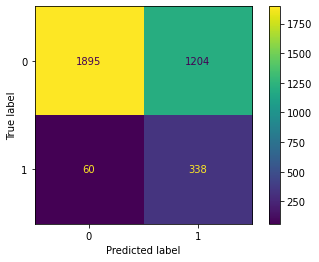

In [300]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(righty_test_y1, righty_preds_final)).plot()

In [301]:
righty_preds = (RFCLF_r2.predict_proba(righty_test_X_scaled)[:,1] > righty_threshold) * 1
print(classification_report(righty_test_y, righty_preds))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3099
           1       0.30      0.06      0.09       398

    accuracy                           0.88      3497
   macro avg       0.59      0.52      0.51      3497
weighted avg       0.82      0.88      0.84      3497



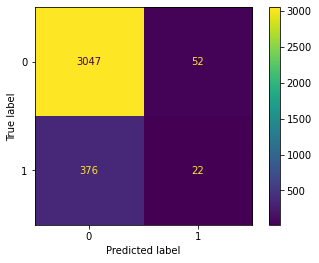

In [302]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(righty_test_y, righty_preds)).plot()

For righties, we do even better with this task, obtaining a recall of 85%.

We've done a lot better with the more lightweight model on a bigger dataset. As the feature importances below show, this had pretty much nothing to do with clustering information from section 1. What combination of more limited features, bigger data, or other factors (I consider some in my conclusion) led to this improvement are unknown to me, but it was probably indeed a combination leading to this improvement.  

Furthermore, striving for 20% precision is arbritrary. Higher precision can be obtained by sacrificing some of these much higher recalls of about 80%.

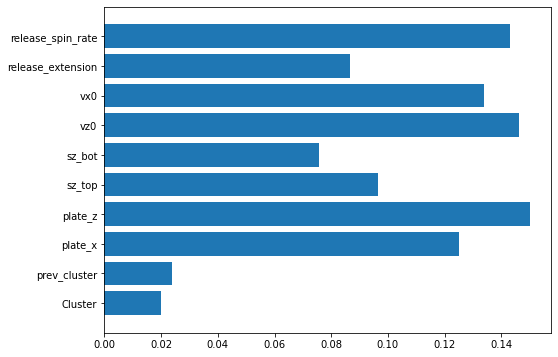

In [303]:
#new lefty feature importances
plt.figure(figsize=(8,6))
nfeat=lefty_train_X_2.shape[1]
plt.barh(np.arange(nfeat), RF_L_temp.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(lefty_train_X_2.columns))
plt.ylim(-1,nfeat)
plt.show()

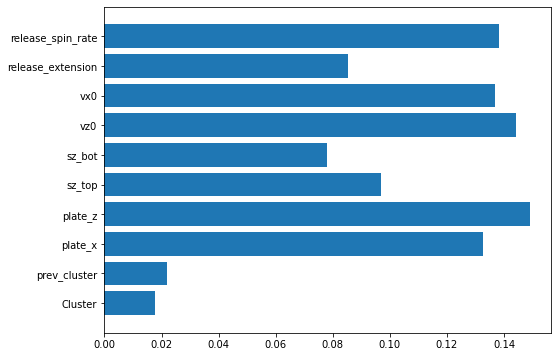

In [304]:
#new righty feature importances
plt.figure(figsize=(8,6))
nfeat=righty_train_X_2.shape[1]
plt.barh(np.arange(nfeat), RF_R_temp.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(righty_train_X_2.columns))
plt.ylim(-1,nfeat)
plt.show()

# **Conclusion**

My analysis addressed both parts of my original question -- of whether data indicates baseball pitch typologies differing from convention and whether this info can be used to predict effectiveness -- with differing levels of effectiveness (though it's probably a stretch to compare the effectiveness of supervised versus unsupervised modeling analyses).

In Section 1, the k-means clustering algorithm's use on Statcast pitch data showed that pitches do in fact fall into three broad categories based on their in-air movement, which is consistent with conventional widsom, but that some pitches labeled as fastballs actually act more like breaking balls or off-speed pitches -- especially cutters and sinkers. This indicates we might want to think about re-classifying some of these fastballs, or at least about thinking about them differently.  

The other key conclusion from Section 1 is that the data indicates lefties may get by on inferior pitch quality, if we can define quality as extremes of speed and break, because they're weirder. Pitches of the fastball archetype from lefties tend to be slower, but the range of velocities is wider than that of righties. Further analyses of this would likely involve testing for whether these differences are statistically significant to better understand whether/how much lefties have a leg up.  

In Sections 2 and 3, I had debatable success trying to get at the second part of my question: whether we can predict pitch effectiveness and if the unsupervised learning info helps in that regard. Regarding the latter part of my second question, we can say pretty confidently I was unable to translate my section 1 findings into better predictive power, given the feature importances. However, I did otherwise appear to have some predictive success at the end, at least when it came to identifying swing and miss pitches while being OK with a very high error rate.  

As mentioned, this improvement could have come because I utilized more of the dataset or because I respecified the model. It also could have come from nuances of this specific dataset. Further analysis is needed to see how this model performs on other sample baseball periods, as I spent a lot of time looking at this one 11-day period. I'm currently unsure if the process that led me to this new-and-improved model -- including specifying a subsequent model based on feature importances from the first -- didn't lead to a sort of overfitting or introduce an element of data leakage I haven't caught on to.  

Nevertheless, some headway appears to have been made at the difficult task of predicting swings and misses. It's likely only so high an accuracy can be achieved in this task, especially considering the importance of the batter himself in this dynamic. Batters are usually very aware of and prepared for what a given pitcher brings to the table -- i.e. their pitch arsenal -- which, for a given pitcher, is relatively limited compared to the vast range of possibilities found across Major League Baseball. Still, I have a hunch that this preparation can only go so far against truly great pitches (e.g. a 100-mph fastball placed up in the strike zone or a curveball that breaks 3 feet.).  

At the very least, showing that we can identify, with reasonable recall, pitches that are 'swing-and-miss' material is of interest, as this is, again, a sign of pitch effectiveness/quality and, incidentally, very important in certain in-game situations such as when a runner is on third base. 